# Exposure Time Calculator

MASS Astrophysical Techniques – Homework 3 (2024/2025) \
Thara Caba

## Task 1

Write a program in Python that, based on the input characteristics of the telescope (mirror diameter $D$ and f-number $f/\#$), properties of the CCD chip ($q$, $S_\text{dc}$, $S_\text{ro}^2$, $u$), the observed object 
(magnitude $V$, seeing/PSF $r$), and the characteristics of the sky at the observatory site ($S_\text{sky}$), calculates the exposure time needed to achieve a given SNR. 

Assume the source's shape corresponds to a circular aperture of a given radius $r$ (in arcseconds), that the observation is conducted in the $V$-filter with a bandwidth of $900\,\text{\AA}$ (Assume that the flux is constant within this interval. This assumption is valid because we are 
estimating the order of magnitude for the exposure time, not its exact value. Otherwise, things become more complicated.). Assume the object is at the zenith ($X = 1$), and the flux for a zero-magnitude source is $f_0 = 1000\,\text{e}^-/\text{s}/\text{cm}^2/\text{\AA}$. Provide plots showing the dependence of the exposure time from: 

1. SNR = 3,1003 for $r = \{0.01, 0.1, 0.5, 1, 3\}$ arcsec
2. $V = 10,30$ for $D = \{1, 2.5, 6, 11\}$ m
3.  $B_\text{sky} = 18,24$ mag/arcsec$^2$ for $r = \{0.01, 0.1, 0.5, 1, 3\}$ arcsec
4.  $q = 0.35,0.99$ for $u = \{5, 14, 27, 50\}\,\mu$m

The above task is for a point source. However, the exposure time can also be estimated for an extended source (e.g., a galaxy). Assume the source brightness is $B_\text{sig} = 25$ mag/arcsec$^2$ and that it covers $4 \times 4$ pixels on the CCD chip. Provide plots showing changes in exposure time for SNR = $[3, 1003]$ and $n = \{4, 15, 70\}$. 

Unless otherwise stated, assume the following default parameters: 

$D = 8\,\text{m}$, $q = 0.7$, $V = 25^m$
$f/\# = 2.77$, $S_\text{dc} = 3\,\text{e}^-/\text{s}/\text{pix}$, $B_\text{sky} = 22\,\text{mag}/\text{arcsec}^2$
$S_\text{ro}^2 = 5\,\text{e}^-/\text{pix}$, $r = 2\,\text{arcsec}$
$u = 27\,\mu$m, $\text{SNR} = 10$

The report can be submitted in the form of a Jupyter notebook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Default parameters
D = 8  # Mirror diameter in meters
q = 0.7  # Quantum efficiency
V = 25  # Magnitude of the object
f_number = 2.77  # f/#
S_dc = 3  # Dark current in e-/s/pix
B_sky = 22  # Sky brightness in mag/arcsec^2
S_ro2 = 5  # Read-out noise in e-/pix
r = 2  # PSF radius in arcseconds
u = 27  # Pixel size in micrometers
SNR_target = 10  # Target signal-to-noise ratio
f0 = 1000  # Flux for a zero-magnitude source in e-/s/cm^2/Å
bandwidth = 900  # V-filter bandwidth in Å
X = 1  # Zenith factor

In [3]:
# Functions for calculations
def magnitude2flux(magnitude, reference_flux=f0):
    """Calculate the flux in in e-/s/cm^2/Å for a given magnitude."""
    return reference_flux * 10**(-0.4 * magnitude)

def num_pixels_covered(psf_radius=r,
                       focal_length=D*f_number,
                       pixel_size=u):
    return np.pi * ((psf_radius * focal_length * 1E6) / (206265 * pixel_size))**2

def magnitude2electrons(magnitude,
                        reference_flux=f0,
                        aperture=D,
                        quantum_efficiency=q,
                        bandwidth=bandwidth):
    """Calculate electrons per second per unit wavelength. """
    flux = magnitude2flux(magnitude=magnitude, reference_flux=reference_flux)
    return bandwidth * quantum_efficiency * flux * np.pi * (50 * aperture)**2

def magnitude2electrons_per_pixel(magnitude,
                                  reference_flux=f0,
                                  pixel_size=u,
                                  psf_radius=r,
                                  focal_ratio=f_number,
                                  quantum_efficiency=q,
                                  bandwidth=bandwidth):
    """Calculate electrons per second per unit wavelength per pixel."""
    flux = magnitude2flux(magnitude=magnitude, reference_flux=reference_flux)
    return (bandwidth * quantum_efficiency * flux * 206265**2 * pixel_size**2 * 1E-8) / (4 * psf_radius**2 * focal_ratio**2)

def exposure_time(source_mag=V,
                  reference_flux=f0,
                  aperture=D,
                  bandwidth=bandwidth,
                  quantum_efficiency=q,
                  sky_mag=B_sky,
                  pixel_size=u,
                  psf_radius=r,
                  focal_ratio=f_number,
                  S_dc=S_dc,
                  S_ro2=S_ro2,
                  SNR=SNR_target):
    S_sig = magnitude2electrons(magnitude=source_mag,
                                reference_flux=reference_flux,
                                aperture=aperture,
                                quantum_efficiency=quantum_efficiency,
                                bandwidth=bandwidth)
    S_sky = magnitude2electrons_per_pixel(magnitude=sky_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    num_pixels = num_pixels_covered(psf_radius=psf_radius,
                                    focal_length=aperture*focal_ratio,
                                    pixel_size=pixel_size)
    R_sky = S_sky * num_pixels
    
    time_dep_noise = S_sig + R_sky + S_ro2 * num_pixels
    return SNR * ((SNR * time_dep_noise + np.sqrt(SNR**2 * time_dep_noise**2 + 4 * S_sig**2 * S_ro2 * num_pixels)) / (2 * S_sig**2))

def exposure_time(source_mag=V,
                  reference_flux=f0,
                  aperture=D,
                  bandwidth=bandwidth,
                  quantum_efficiency=q,
                  sky_mag=B_sky,
                  pixel_size=u,
                  psf_radius=r,
                  focal_ratio=f_number,
                  S_dc=S_dc,
                  S_ro2=S_ro2,
                  SNR=SNR_target):
    S_sig = magnitude2electrons_per_pixel(magnitude=source_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    S_sky = magnitude2electrons_per_pixel(magnitude=sky_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    num_pixels = num_pixels_covered(psf_radius=psf_radius,
                                    focal_length=aperture*focal_ratio,
                                    pixel_size=pixel_size)
    S_sig = S_sig * num_pixels
    R_sky = S_sky * num_pixels
    S_dc = S_dc * num_pixels
    
    time_dep_noise = S_sig + R_sky + S_dc
    return SNR * ((SNR * time_dep_noise + np.sqrt(SNR**2 * time_dep_noise**2 + 4 * S_sig**2 * S_ro2 * num_pixels)) / (2 * S_sig**2))

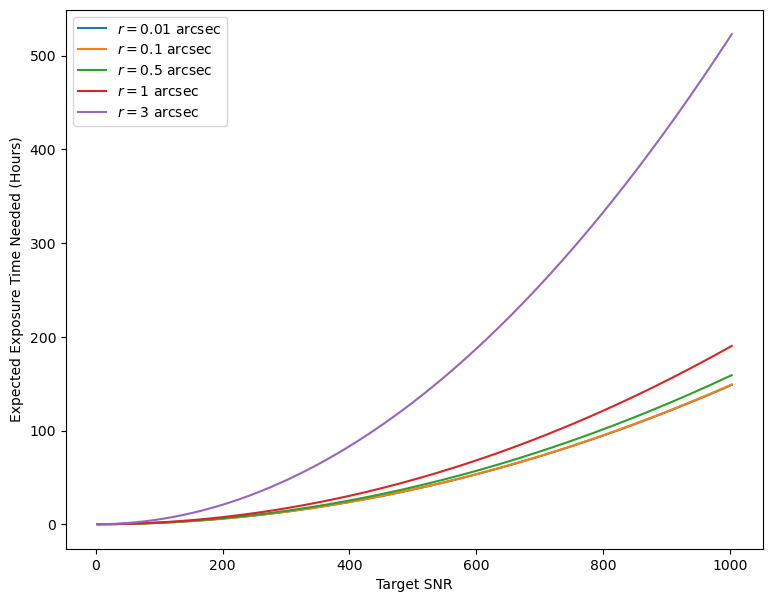

In [4]:
# Run the plotting functions
times = []

SNRs = np.linspace(3, 1003, 200)
r_array = [0.01, 0.1, 0.5, 1, 3]

for r in r_array:
    time_array = exposure_time(psf_radius=r, SNR=SNRs)
    times.append(time_array)

plt.figure(figsize=(9,7))

for r, time_array in zip(r_array, times):
    plt.plot(SNRs, time_array/3600, label=f'$r = {r}$ arcsec')

plt.xlabel('Target SNR')
plt.ylabel('Expected Exposure Time Needed (Hours)')

plt.legend()
plt.show()

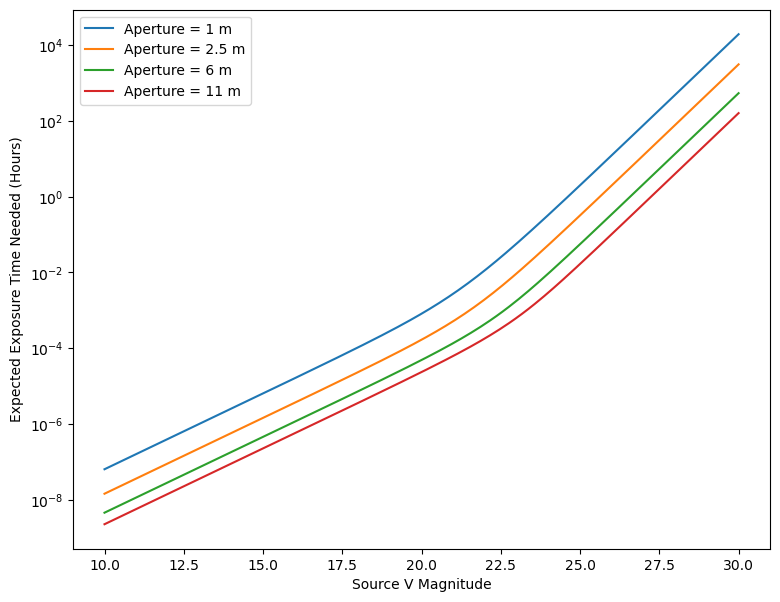

In [5]:
times = []

Vs = np.linspace(10, 30, 200)
D_array = [1, 2.5, 6, 11]

for D in D_array:
    time_array = exposure_time(source_mag=Vs, aperture=D)
    times.append(time_array)

plt.figure(figsize=(9,7))

for D, time_array in zip(D_array, times):
    plt.plot(Vs, time_array/3600, label=f'Aperture = {D} m')

plt.xlabel('Source V Magnitude')
plt.ylabel('Expected Exposure Time Needed (Hours)')

plt.yscale('log')

plt.legend()
plt.show()

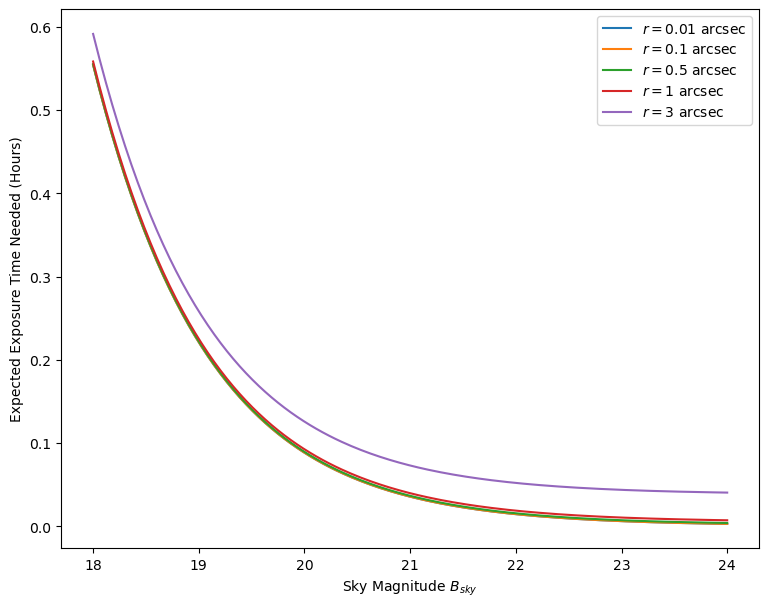

In [6]:
times = []

B_skys = np.linspace(18, 24, 200)
r_array = [0.01, 0.1, 0.5, 1, 3]

for r in r_array:
    time_array = exposure_time(sky_mag=B_skys, psf_radius=r)
    times.append(time_array)

plt.figure(figsize=(9,7))

for r, time_array in zip(r_array, times):
    plt.plot(B_skys, time_array/3600, label=f'$r = {r}$ arcsec')

plt.xlabel('Sky Magnitude $B_{sky}$')
plt.ylabel('Expected Exposure Time Needed (Hours)')

# plt.yscale('log')

plt.legend()
plt.show()

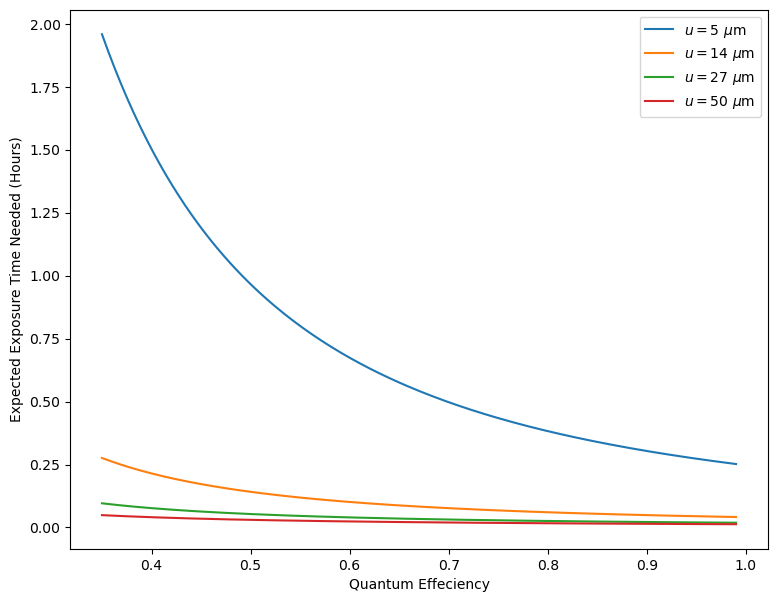

In [7]:
times = []

qs = np.linspace(0.35, 0.99, 200)
u_array = [5, 14, 27, 50]

for u in u_array:
    time_array = np.array([exposure_time(quantum_efficiency=q, pixel_size=u) for q in qs])
    times.append(time_array)

plt.figure(figsize=(9,7))

for u, time_array in zip(u_array, times):
    plt.plot(qs, time_array/3600, label=f'$u = {u}~\mu$m')

plt.xlabel('Quantum Effeciency')
plt.ylabel('Expected Exposure Time Needed (Hours)')

# plt.yscale('log')

plt.legend()
plt.show()

In [8]:
def exposure_time_extended(source_mag=V,
                           reference_flux=f0,
                           aperture=D,
                           bandwidth=bandwidth,
                           quantum_efficiency=q,
                           sky_mag=B_sky,
                           pixel_size=u,
                           psf_radius=r,
                           focal_ratio=f_number,
                           S_dc=S_dc,
                           S_ro2=S_ro2,
                           SNR=SNR_target,
                           num_pixels=4):
    
    S_sig = magnitude2electrons_per_pixel(magnitude=source_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    
    S_sig = S_sig * num_pixels
    
    S_sky = magnitude2electrons_per_pixel(magnitude=sky_mag,
                                          reference_flux=reference_flux,
                                          pixel_size=pixel_size,
                                          psf_radius=psf_radius,
                                          focal_ratio=focal_ratio,
                                          quantum_efficiency=quantum_efficiency,
                                          bandwidth=bandwidth)
    R_sky = S_sky * num_pixels
    S_dc = S_dc * num_pixels
    
    time_dep_noise = S_sig + R_sky + S_dc
    return SNR * ((SNR * time_dep_noise + np.sqrt(SNR**2 * time_dep_noise**2 + 4 * S_sig**2 * S_ro2 * num_pixels)) / (2 * S_sig**2))

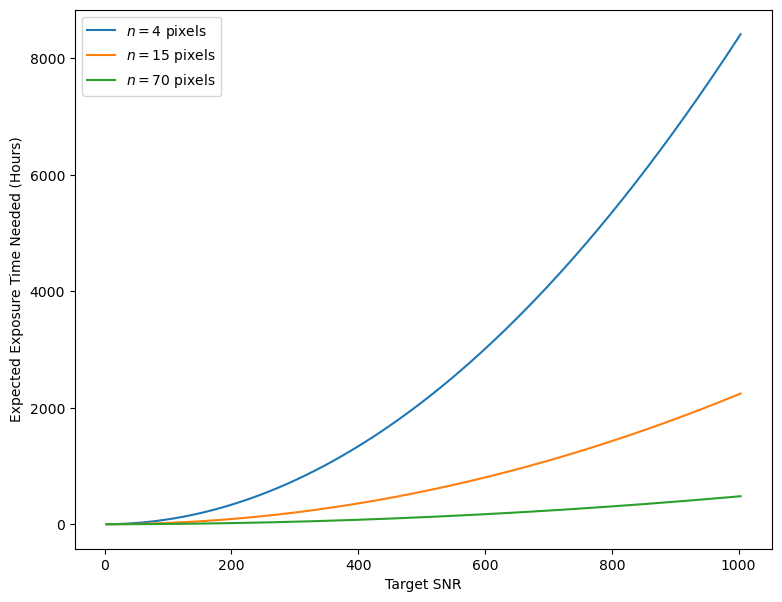

In [9]:
times = []

SNRs = np.linspace(3, 1003, 200)
n_array = [4, 15, 70]

for n in n_array:
    time_array = exposure_time_extended(SNR=SNRs, num_pixels=n)
    times.append(time_array)

plt.figure(figsize=(9,7))

for n, time_array in zip(n_array, times):
    plt.plot(SNRs, time_array/3600, label=f'$n = {n}$ pixels')

plt.xlabel('Target SNR')
plt.ylabel('Expected Exposure Time Needed (Hours)')

plt.legend()
plt.show()

## Task 2

Calculate the exposure time for the Andromeda Galaxy (M31) to be observed with the Milanković telescope equipped with an SBIG STXL-6303E CCD camera. 
Assume the sky brightness is $B_\text{sky} = 19\,\text{mag}/\text{arcsec}^2$. The required SNR is 100. 

In [10]:
milankovic_pixel_scale = ((206265 * 9 * 1E-6) / 11.2)**2
andromeda_sky_area = 10680*3780 # arcsec^2
andromeda_num_pixels = andromeda_sky_area / milankovic_pixel_scale

print(f'Andromeda would cover around {int(andromeda_num_pixels):,} pixels on the CCD in total if the CCD was big enough.')

Andromeda would cover around 1,469,477,689 pixels on the CCD in total if the CCD was big enough.


In [11]:
# New parameters
D = 1.4  # Mirror diameter in meters
q = 0.68  # Quantum efficiency
V = 3.4  # Magnitude of the object
f_number = 8  # f/#
S_dc = 0.3  # Dark current in e-/s/pix
B_sky = 19  # Sky brightness in mag/arcsec^2
S_ro2 = 11  # Read-out noise in e-/pix
r = 2  # PSF radius in arcseconds
u = 9  # Pixel size in micrometers
SNR_target = 100  # Target signal-to-noise ratio
f0 = 1000  # Flux for a zero-mag7689nitude source in e-/s/cm^2/Å
bandwidth = 900  # V-filter bandwidth in Å
X = 1  # Zenith factor

In [12]:
exposure_time_extended(source_mag=V,
                       reference_flux=f0,
                       aperture=D,
                       bandwidth=bandwidth,
                       quantum_efficiency=q,
                       sky_mag=B_sky,
                       pixel_size=u,
                       psf_radius=r,
                       focal_ratio=f_number,
                       S_dc=S_dc,
                       S_ro2=S_ro2,
                       SNR=SNR_target,
                       num_pixels=3072*2048)

1.4795969673392683e-07